In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from jax import vmap
from jaxtyping import Array
from adsprites import DSprites

In [3]:
task = DSprites(batch_size=64, seed=101)
task.imgs.dtype

dtype('uint8')

In [4]:
imgs = []
for i in range(3):
    state = jnp.array([0, i, 0, 0, 0, 0])
    indx = task.state_to_index(state)
    imgs.append(task.imgs[indx][..., 10:22, 10:22])

test_img = imgs[0].astype(jnp.float32)
task.state_sizes

array([ 1,  3,  6, 40, 32, 32])

In [5]:
from itertools import product

states = jnp.array(list(product(range(6), range(1), range(32), range(32))))
states = jnp.pad(states, ((0, 0), (2, 0)))
data_indexes = task.state_to_index(states)
print(len(data_indexes))

6144


In [6]:
from equinox import Module
from jax.scipy.ndimage import map_coordinates

# https://kevinzakka.github.io/2017/01/10/stn-part1/
# https://kevinzakka.github.io/2017/01/18/stn-part2/

class SpatialTransformerNetwork(Module):
    height: int 
    width: int
    sampling_grid: Array
    
    def __init__(self, height, width):
        self.height = height
        self.width = width

        # create normalized 2D grid
        x = jnp.linspace(-1, 1, width)
        y = jnp.linspace(-1, 1, height)
        x_t, y_t = jnp.meshgrid(x, y)

        # reshape to (xt, yt, 1)
        ones = jnp.ones(np.prod(x_t.shape))
        self.sampling_grid = jnp.vstack([x_t.flatten(), y_t.flatten(), ones])


    def bilinear_sampler(self, input_img, x, y):
        """
        Performs bilinear sampling of the input images according to the
        normalized coordinates provided by the sampling grid. Note that
        the sampling is done identically for each channel of the input.

        To test if the function works properly, output image should be
        identical to input image when theta is initialized to identity
        transform.

        Input
        -----
        - input_imgs: batch of images in (B, H, W, C) layout.
        - grid: x, y which is the output of affine_grid_generator.

        Returns
        -------
        - interpolated images according to grids. Same size as grid.
        """
        # grab dimensions
        C, H, W = input_img.shape

        max_y = (H - 1)
        max_x = (W - 1)

        # rescale x and y to [0, W-1/H-1]
        x = (x + 1.) * max_x * 0.5
        y = (y + 1.) * max_y * 0.5

        mc = lambda img: map_coordinates(img, [x, y], order=1)
        out = vmap(mc)(input_img)

        return out

    def __call__(self, img, θ):

        M = θ.reshape(2, 3)
        batch_grids = (M @ self.sampling_grid).reshape(2, self.height, self.width)
        x, y = batch_grids[0], batch_grids[1]

        return self.bilinear_sampler(img, x, y)

stn = SpatialTransformerNetwork(64, 64)

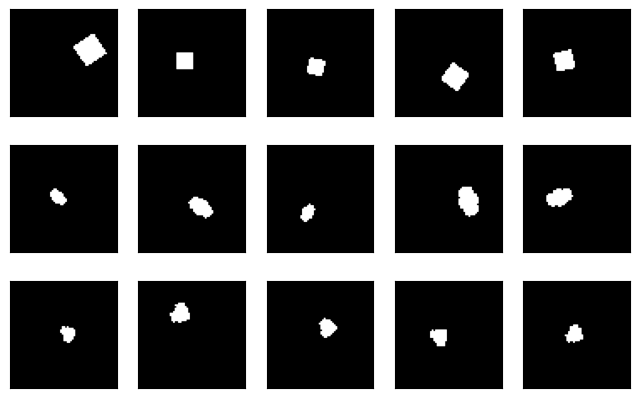

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(8, 5), sharex=True, sharey=True)

for i, img in enumerate(imgs):
    loc_img = img
    for ax in axes[i]:
        z = np.random.normal(size=4)
        s = 5 + z[0]
        cos = np.cos(z[1])
        sin = np.sin(z[1])
        θ = jnp.array([s * cos, - s * sin, z[2], s * sin, s * cos, z[3]])
        out_img = stn(loc_img, θ)
        ax.imshow(out_img.transpose(1, 2, 0), cmap='Greys_r')
        ax.set_xticks(ticks=[])
        ax.set_yticks(ticks=[])

In [8]:
import equinox.nn as enn
from equinox import filter_jit, Module
from typing import List, Callable
import jax.random as jr
from jax import vmap, nn

import bmr4pml.nn as bnn

class Encoder(Module):
    patch_embed: bnn.Patch
    layers: List[enn.Linear]
    act: Callable

    def __init__(self, z_dim, hidden_dim, img_size, patch_size=8, activation=nn.relu, *, key):
        
        key, _key = jr.split(key)
        self.patch_embed = bnn.PatchConvEmbed(
            img_size = img_size,
            patch_size = patch_size,
            in_chans = 1,
            embed_dim = hidden_dim,
            key = _key
        )

        num_patches = (img_size // patch_size) ** 2

        self.layers = []
        self.act = activation

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(num_patches * hidden_dim, num_patches // 2 * hidden_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(num_patches // 2 * hidden_dim, z_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(num_patches // 2 * hidden_dim, z_dim, key=_key))

    def __call__(self, x):
        x = x.astype(jnp.float32)
        z = self.patch_embed(x).reshape(-1)
        z = self.act(z)

        z = self.layers[0](z)
        z = self.act(z)

        loc = self.layers[-2](z)
        scale = nn.softplus(self.layers[-1](z))

        return loc, scale
    
class Decoder(Module):
    layers: List[enn.Linear]
    act: Callable

    def __init__(self, z_dim, hidden_dim, output_dim, activation=nn.relu, *, key):

        self.layers = []
        self.act = activation

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(z_dim, hidden_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(hidden_dim, output_dim, key=_key))

    def __call__(self, z):

        h = self.layers[0](z)
        h = self.act(h)

        θ = self.layers[1](h)

        return θ
    
class RNN(Module):
    layers: List[enn.Linear]
    act: Callable

    def __init__(self, z_dim, activation=nn.relu, *, key):

        self.layers = []
        self.act = activation

        input_dim = 4 * z_dim
        hidden_dim = 2 * input_dim
        key, _key = jr.split(key)
        self.layers.append(enn.Linear(input_dim, hidden_dim, key=_key))

        output_dim = 2 * z_dim
        key, _key = jr.split(key)
        self.layers.append(enn.Linear(hidden_dim, output_dim, key=_key))

    def __call__(self, η, nabla_L):

        z = jnp.concatenate([η, nabla_L])

        z = self.layers[0](z)
        z = self.act(z)

        z = self.layers[1](z)

        return z

In [9]:
import equinox as eqx
import numpyro
import jax.tree_util as jtu

def init_fn(rng_key, shape, radius=0.05):
    return jr.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(layer):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(layer, is_leaf=is_linear) if is_linear(x)]

def register_nnet_params(name, nnet, layers):
    new_layers = []
    for l, layer in enumerate(layers):
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        params = numpyro.param(f'{name}.layer{l}.params', lambda key: init_fn(key, shape))

        if bias is None:
            weight = params.reshape(weight.shape)
        else:
            if len(weight.shape) > 1:
                assert bias.shape[:1] == weight.shape[:1]
            else:
                assert bias.shape == weight.shape
            weight = params[..., :-1].reshape(weight.shape)
            bias = params[..., -1].reshape(bias.shape)
        
        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    nnet = eqx.tree_at(get_linear_layers, nnet, new_layers)

    return nnet

In [71]:
from jax import grad, jit, lax
key = jr.PRNGKey(1101)

def nnet(z):
    s = z[0]
    θ = jnp.stack([s, 0, z[1], 0, s, z[2]], -1)
    return stn(test_img, θ)

def log_likelihood(z, target_img):
    x = target_img.astype(jnp.float32)
    y = nnet(z).astype(jnp.float32)
    π = nn.softplus(- 1.5)
    loss = .5 * π * jnp.square(x - y).sum() + jnp.log(2 * jnp.pi / π) / 2
    return loss

def plot_results(sequence, target_img, prior_img, axes, n, d=3):
    axes[0].plot(sequence[0])
    axes[1].plot(sequence[1])

    axes[2].imshow(target_img.transpose(1, 2, 0), cmap='Greys_r')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].imshow(prior_img)

    μ = sequence[0][-1] / sequence[1][-1]
    scale = jnp.sqrt(1/sequence[1][-1])
    z = μ[:d] + scale[:d] * np.random.randn(n, d)
    out_img = vmap(nnet)(z).mean(0)
    axes[-1].imshow(out_img.transpose(1, 2, 0), vmin=0, vmax=1)
    axes[-1].set_xticks([])
    axes[-1].set_yticks([])

df = grad(log_likelihood)

n = 100
d = 3
init_mu = nn.one_hot(0, d) * 4.
init_pi = jnp.ones(d)

scale = jnp.sqrt(1/init_pi[:d])
z = init_mu[:d] + scale * np.random.randn(n, d)
prior_img = vmap(nnet)(z).mean(0)

S = 8
λ = jnp.ones(d)

tmp = prior_img[0]
alpha = np.sqrt(tmp)
prior_img = jnp.stack(
    [tmp, 
     jnp.zeros_like(tmp), 
     jnp.zeros_like(tmp), 
     alpha
     ], 
    -1).astype(np.float32)

In [ ]:
optax.adam()

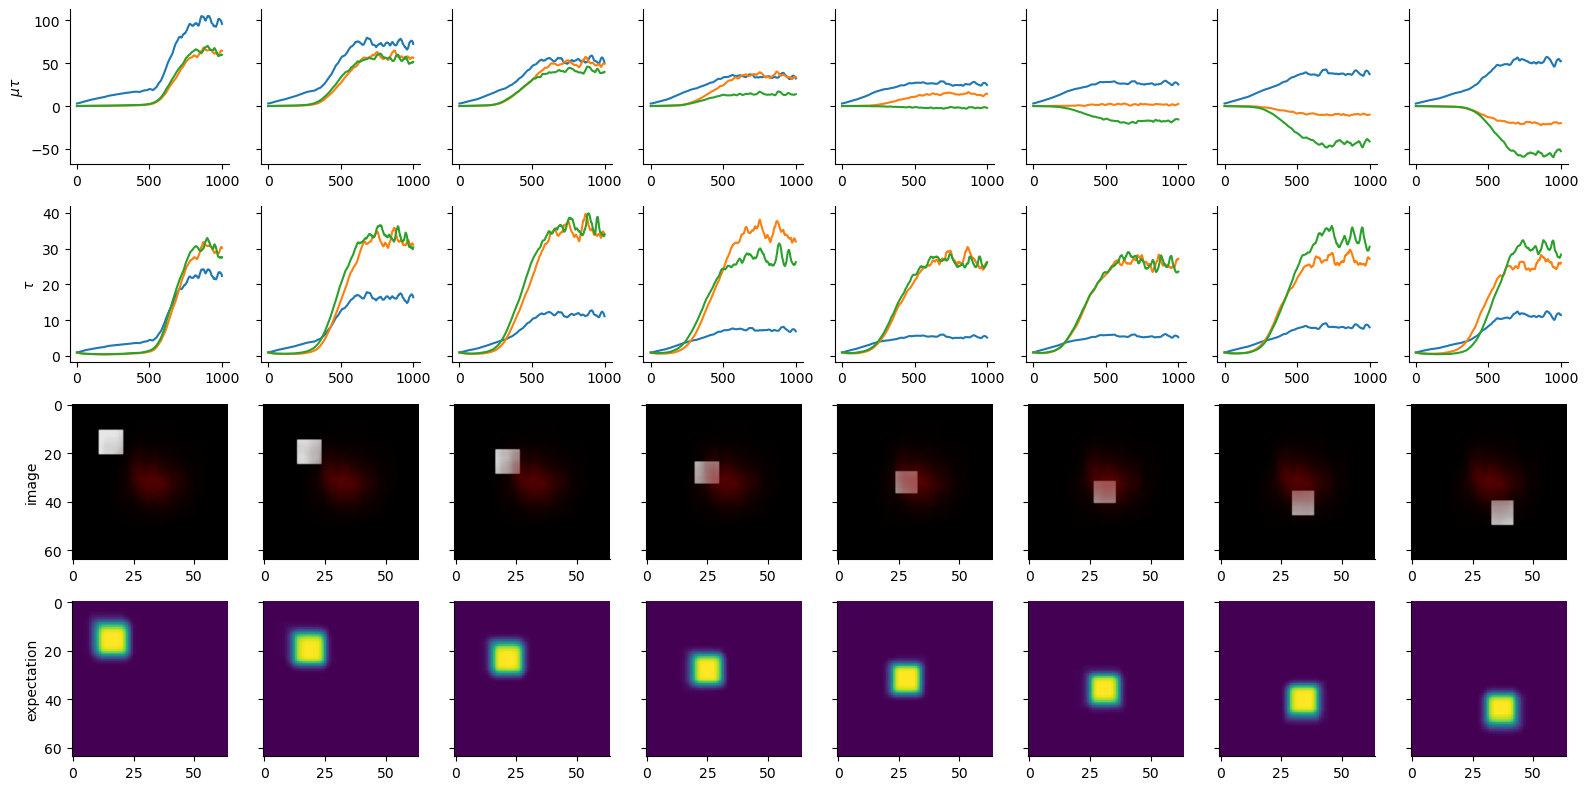

In [69]:
import optax
size = 8
fig, axes = plt.subplots(4, size, figsize=(16, 8), sharex='row', sharey='row')
optim = optax.adam(learning_rate=1e-2, b1=0.9, b2=0.99)

for i, indx in enumerate(data_indexes[::100][:size]):
    target_img = task.imgs[indx]
    def loss(params, key):
        μ = params['mu']
        scale = nn.softplus(params['ln_pi'])
        eps = jr.normal(key, shape=(S, *μ.shape))
        x = μ + scale * eps
        loss = vmap(log_likelihood, in_axes=(0, None))(x, target_img).mean(0)
        loss += jnp.sum( λ * μ ** 2 / 2 + (λ * scale ** 2 - 1 - 2 * jnp.log(scale) - jnp.log(λ) ) / 2)
        return loss

    _df = grad(loss)

    def step_fn(carry, t):
        state, opt_state, key = carry
        key, _key = jr.split(key)
        grads = _df(state, _key)
        updates, opt_state = optim.update(grads, opt_state)
        state = optax.apply_updates(state, updates)
        π = 1 / nn.softplus(state['ln_pi']) ** 2
        return (state, opt_state, key), (state['mu'] * π, π)

    key, _ = jr.split(key)
    init = { 'mu': nn.one_hot(0, d) * 3.,
             'ln_pi': jnp.zeros(d) + .55 }
    opt_state = optim.init( init )
    last, sequence = lax.scan(step_fn, (init, opt_state, key), jnp.arange(1000))
    plot_results(sequence, target_img, prior_img, axes[:, i], n, d=d)


axes[0, 0].set_ylabel(r'$\mu \tau $')
axes[1, 0].set_ylabel(r'$\tau $')
axes[2, 0].set_ylabel(r'image')
axes[3, 0].set_ylabel(r'expectation')
fig.tight_layout()
sns.despine(fig)

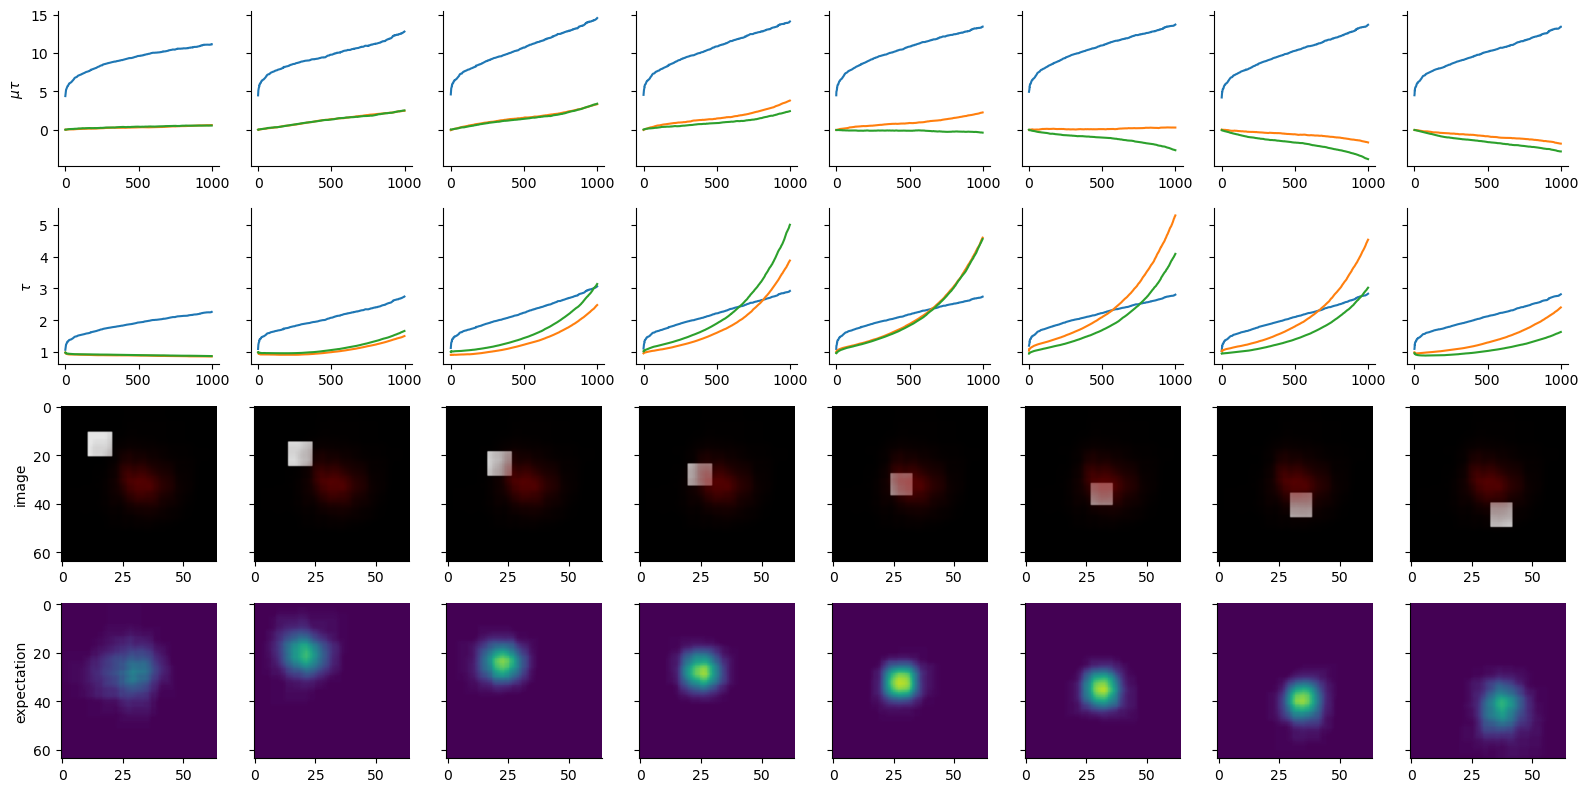

In [65]:
size = 8
fig, axes = plt.subplots(4, size, figsize=(16, 8), sharex='row', sharey='row')

for i, indx in enumerate(data_indexes[::100][:size]):
    α_0 = 1e-2
    β_1 = 0.9
    β_2 = 0.99
    target_img = task.imgs[indx]
    def step_fn(carry, t):
        μ, π, key = carry
        key, _key = jr.split(key)
        eps = jr.normal(_key, shape=(S, *μ.shape))
        scale = jnp.sqrt(1/π)
        x = μ + scale * eps
        g = vmap(df, in_axes=(0, None))(x, target_img)
        
        lr = α_0 * (1 - β_2 ** 2) / (1 - jnp.power(β_2, 2 * (t + 1)))
        u = lr * ( (g * eps).mean(0) / scale + λ - π)
        π = jnp.exp(u) * π
        π = jnp.clip(π, a_min=1e-12)
        
        lr = α_0 * (1 - β_1 ** 2) / (1 - jnp.power(β_1, 2 * (t + 1)))
        μ = μ - lr * (g.mean(0) + λ * μ) / π
        return (μ, π, key), (μ * π, π)

    key, _ = jr.split(key)
    last, sequence = lax.scan(step_fn, (init_mu, init_pi, key), jnp.arange(1000))
    plot_results(sequence, target_img, prior_img, axes[:, i], n, d=d)

axes[0, 0].set_ylabel(r'$\mu \tau $')
axes[1, 0].set_ylabel(r'$\tau $')
axes[2, 0].set_ylabel(r'image')
axes[3, 0].set_ylabel(r'expectation')
fig.tight_layout()
sns.despine(fig)

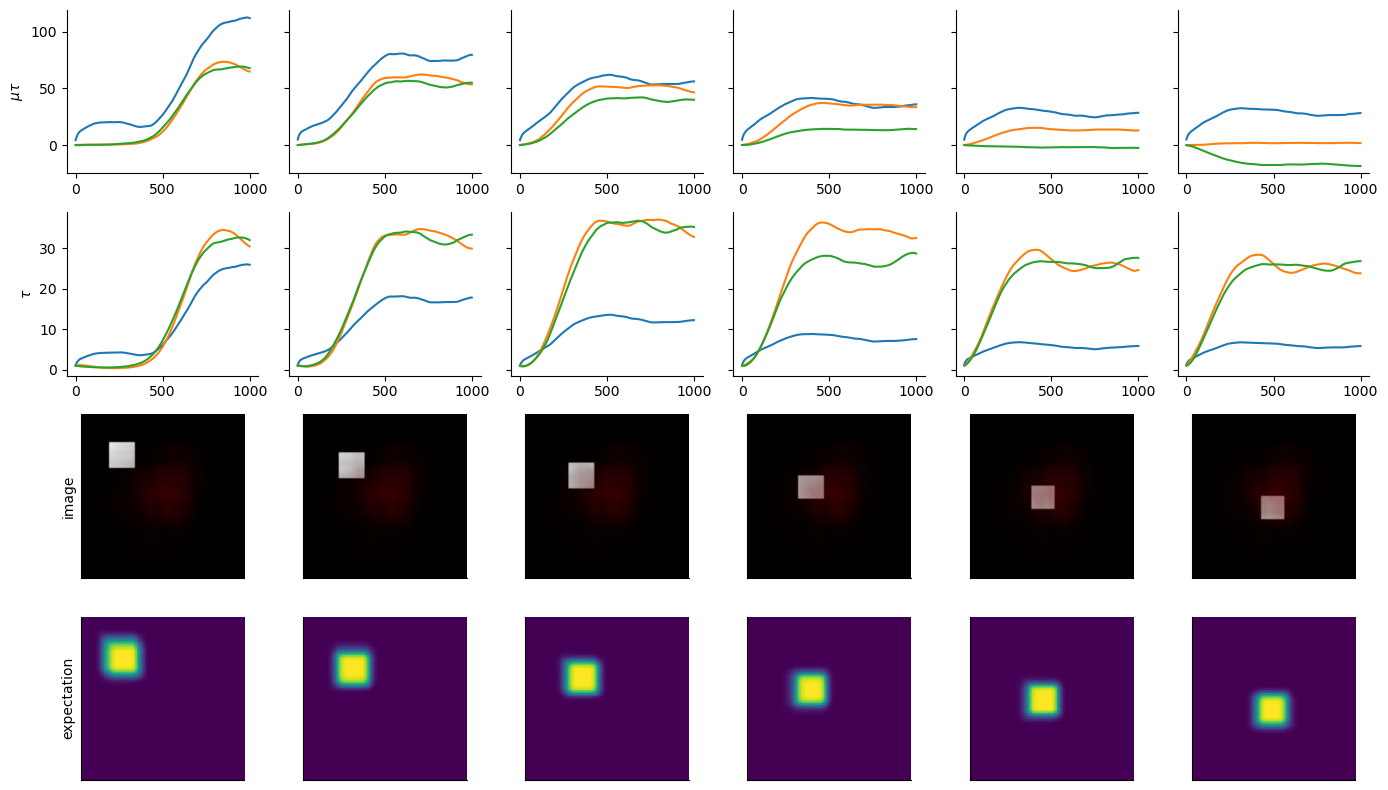

In [78]:
size = 6
fig, axes = plt.subplots(4, size, figsize=(14, 8), sharex='row', sharey='row')

for i, indx in enumerate(data_indexes[::100][:size]):
    α_0 = 1e-2
    γ_1 = 0.9
    γ_2 = 0.99
    target_img = task.imgs[indx]
    def step_fn(carry, t):
        μ, μ_1, π, π_1, key = carry
        key, _key = jr.split(key)
        eps = jr.normal(_key, shape=(S, *μ.shape))
        scale = jnp.sqrt(1/π)
        x = μ + scale * eps
        g = vmap(df, in_axes=(0, None))(x, target_img)
        
        α_t = α_0 * (1 - γ_2) / (1 - jnp.power(γ_2, t + 1))
        γ_t = γ_2 * (1 - jnp.power(γ_2, t)) / (1 - jnp.power(γ_2, t + 1))
        
        _π = π +  γ_t * (π - π_1) +  α_t * ( (g * eps).mean(0) / scale + λ - π)
        _π = jnp.clip(_π, a_min=1e-6)

        α_t = α_0 * (1 - γ_1) / (1 - jnp.power(γ_1, t + 1))
        γ_t = γ_1 * (1 - jnp.power(γ_1, t)) / (1 - jnp.power(γ_1, t + 1))
        _μ = μ - α_t * (g.mean(0) + λ * μ) / _π + γ_t * π_1 * (μ - μ_1) / _π

        return (_μ, μ, _π, π, key), (_μ * _π, _π)

    key, _ = jr.split(key)
    init = (init_mu, init_mu, init_pi, init_pi, key)
    last, sequence = lax.scan(step_fn, init, jnp.arange(1000))
    plot_results(sequence, target_img, prior_img, axes[:, i], n, d=d)

axes[0, 0].set_ylabel(r'$\mu \tau $')
axes[1, 0].set_ylabel(r'$\tau $')
axes[2, 0].set_ylabel(r'image')
axes[3, 0].set_ylabel(r'expectation')

fig.tight_layout()
sns.despine(fig)

## Iterative amortized inference

In [15]:
import optax
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceGraph_ELBO
from numpyro import handlers

In [35]:
from jax import remat

num_steps = 1000
def infer_posterior_params(key, batch_data):
    α_0 = 1e-2
    γ_1 = 0.9
    γ_2 = 0.99
    key = lax.stop_gradient(key)
    batch_data = lax.stop_gradient(batch_data)

    def posterior(key, target_img):
        def step_fn(carry, t):
            μ, μ_1, π, π_1, key = carry
            key, _key = jr.split(key)
            eps = jr.normal(_key, shape=(S, *μ.shape))
            scale = jnp.sqrt(1/π)
            x = μ + scale * eps
            g = vmap(df, in_axes=(0, None))(x, target_img)
            
            α_t = α_0 * (1 - γ_2) / (1 - jnp.power(γ_2, t + 1))
            γ_t = γ_2 * (1 - jnp.power(γ_2, t)) / (1 - jnp.power(γ_2, t + 1))
            
            _π = π +  γ_t * (π - π_1) +  α_t * ( (g * eps).mean(0) / scale + λ - π)
            _π = jnp.clip(_π, a_min=1e-16)

            α_t = α_0 * (1 - γ_1) / (1 - jnp.power(γ_1, t + 1))
            γ_t = γ_1 * (1 - jnp.power(γ_1, t)) / (1 - jnp.power(γ_1, t + 1))
            _μ = μ - α_t * (g.mean(0) + λ * μ) / _π + γ_t * π_1 * (μ - μ_1) / _π

            return (_μ, μ, _π, π, key), None
        
        init = (
            init_mu,
            init_mu,
            init_pi,
            init_pi,
            key
        )
        post_params, _ = lax.scan(step_fn, init, jnp.arange(num_steps))
        loc = post_params[0]
        scale = jnp.sqrt(1 / post_params[2])
        return loc, scale
    
    keys = jr.split(key, len(batch_data))
    return vmap(posterior)(keys, batch_data)

def grad_μ(g, μ):
    return g + λ * μ

def grad_σ(h, π):
    return .5 * (h  - λ + π)

def grads(g, h, μ, π):
    nabla_M = grad_σ(h, π)
    nabla_m = grad_μ(g, μ) - 2 * nabla_M
    return jnp.concatenate([nabla_m, nabla_M])

num_iters = 1
def iterate_posterior_params(key, rnn, batch_data, init_eta, S=8):

    def step_fn(η, target_img, key):
        π = nn.softplus(η[d:])
        μ = η[:d] / π
        key, _key = jr.split(key)
        eps = jr.normal(_key, shape=(S, *μ.shape))
        scale = jnp.sqrt(1/π)
        x = μ + scale * eps
        g = vmap(df, in_axes=(0, None))(x, target_img)
        h = (g * eps).mean(0) / scale
        nabla_L = grads(g.mean(0), h, μ, π)
        η = rnn(η, nabla_L)
        
        return η
    
    keys = jr.split(key, len(batch_data))
    post_η = vmap(step_fn, in_axes=(None, 0, 0))(init_eta, batch_data, keys)
   
    post_π = nn.softplus(post_η[..., d:])
    post_μ = post_η[..., :d] / post_π
    post_scale = jnp.sqrt(1 / post_π)

    return post_μ, post_scale    

class VAE(object):

    def __init__(self, key, z_dim, img_size, hidden_dim_enc=10, hidden_dim_dec=10):
        
        self.z_dim = z_dim
        # key, _key = jr.split(key)
        # self.decoder = Decoder(z_dim, hidden_dim_dec, 6, key=_key)
        # self.d_layers = get_linear_layers(self.decoder)

        key, _key = jr.split(key)
        self.encoder = Encoder(z_dim, hidden_dim_enc, img_size, key=_key)
        self.e_layers = get_linear_layers(self.encoder)

        key, _key = jr.split(key)
        self.rnn = RNN(z_dim, key=_key)
        self.rnn_layers = get_linear_layers(self.rnn)

        self.stn = SpatialTransformerNetwork(img_size, img_size)

    def decoder(self, z, smpl_img):
        n = z.shape[0]
        zrs = jnp.zeros(n)
        θ = jnp.stack([z[..., 0], zrs, z[..., 1], zrs, z[..., 0], z[..., 2]], -1)
        return vmap(self.stn, in_axes=(None, 0))(smpl_img, θ)
    
    def prior(self, smpl_img, β):
    
        # reg_decoder = register_nnet_params('decoder', self.decoder, self.d_layers)

        # Sample object pose.
        with handlers.scale(scale=β):
            z = numpyro.sample('z', dist.Normal(0., 1.).expand([self.z_dim]).to_event(1))
            # Position/scale object within larger image.
            y = self.decoder(z[..., :self.z_dim], smpl_img)
            scale = jnp.sqrt(1 / nn.softplus(-1.5))
        return y, scale
    
    def model(self, smpl_img, β=1., batch_size=32, data=None):
        N = batch_size if data is None else len(data)
        with numpyro.plate('batch', N, subsample_size=batch_size):
            obs = numpyro.subsample(data, event_dim=3) if data is not None else None
            loc, scale = self.prior(smpl_img, β)
            loc = numpyro.deterministic('imgs', loc)
            numpyro.sample('obs', dist.Normal(loc, scale).to_event(3), obs=obs)

    def mf_guide(self, smpl_img, β=1., batch_size=32, data=None):
        # mean field guide
        assert data is not None
        N = len(data)
        with numpyro.plate('batch', N, subsample_size=batch_size):
            batch_data = numpyro.subsample(data, event_dim=3)
            key = numpyro.prng_key()
            loc, scale = infer_posterior_params(key, batch_data)
            numpyro.deterministic('loc', loc)
            with handlers.scale(scale=β):
                numpyro.sample('z', 
                            dist.Normal(loc, scale).to_event(1)
                            )


    def ai_guide(self, smpl_img, β=1., batch_size=32, data=None):
        # Amortized inference
        reg_encoder = register_nnet_params('encoder', self.encoder, self.e_layers)
        assert data is not None
        N = len(data)
        with numpyro.plate('batch', N, subsample_size=batch_size):
            batch_obs = numpyro.subsample(data, event_dim=3)
            loc, scale = vmap(reg_encoder)(batch_obs)
            loc += nn.one_hot(0, 3) * 4.
            numpyro.deterministic('loc', loc)
            with handlers.scale(scale=β):
                numpyro.sample('z', 
                            dist.Normal(loc, scale).to_event(1)
                            )
                
    def iai_guide(self, smpl_img, β=1., batch_size=32, data=None):
        # iterative amortized inference
        reg_rnn = register_nnet_params('rnn', self.rnn, self.rnn_layers)
        assert data is not None
        N = len(data)
        η_0 = numpyro.param('eta_0', jnp.zeros(self.z_dim * 2))
        with numpyro.plate('batch', N, subsample_size=batch_size):
            batch_data = numpyro.subsample(data, event_dim=3)
            key = numpyro.prng_key()
            loc, scale = iterate_posterior_params(key, reg_rnn, batch_data, η_0)
            numpyro.deterministic('loc', loc)
            with handlers.scale(scale=β):
                numpyro.sample('z', 
                            dist.Normal(loc, scale).to_event(1)
                            )

In [36]:
z_dim = d
img_size = task.imgs.shape[-1]
key = jr.PRNGKey(0)
vae = VAE(key, z_dim, img_size)
train_data = task.imgs[data_indexes].astype(jnp.float32)
with handlers.seed(rng_seed=0):
    vae.model(test_img)
    vae.mf_guide(test_img, batch_size=32, data=train_data)
    vae.ai_guide(test_img, batch_size=32, data=train_data)
    vae.iai_guide(test_img, batch_size=32, data=train_data)

In [37]:
from numpyro.infer import TraceMeanField_ELBO
optim = optax.adabelief(1e-2)
loss = TraceMeanField_ELBO(1)

vae = VAE(key, z_dim, img_size, hidden_dim_enc=8)
scaled_model = handlers.scale(vae.model, scale=1./len(data_indexes))
scaled_guide = handlers.scale(vae.mf_guide, scale=1./len(data_indexes))
svi = SVI(scaled_model, scaled_guide, optim, loss)

key, _key = jr.split(key)
init_state = svi.init(_key, test_img, batch_size=128, data=train_data)
svi.evaluate(init_state, test_img, batch_size=128, data=train_data)

Array(7063.1816, dtype=float32)

In [38]:
from numpyro.infer import TraceMeanField_ELBO
optim = optax.adabelief(1e-2)
loss = TraceMeanField_ELBO(1)

vae = VAE(key, z_dim, img_size, hidden_dim_enc=8)
scaled_model = handlers.scale(vae.model, scale=1./len(data_indexes))
scaled_guide = handlers.scale(vae.ai_guide, scale=1./len(data_indexes))
svi = SVI(scaled_model, scaled_guide, optim, loss)

key, _key = jr.split(key)
init_state = svi.init(_key, test_img, batch_size=128, data=train_data)
svi.evaluate(init_state, test_img, batch_size=128, data=train_data)

Array(7090.2974, dtype=float32)

In [40]:
from numpyro.infer import TraceMeanField_ELBO
optim = optax.adabelief(1e-2)
loss = TraceMeanField_ELBO(1)

vae = VAE(key, z_dim, img_size, hidden_dim_enc=8)
scaled_model = handlers.scale(vae.model, scale=1./len(data_indexes))
scaled_guide = handlers.scale(vae.iai_guide, scale=1./len(data_indexes))
svi = SVI(scaled_model, scaled_guide, optim, loss)

key, _key = jr.split(key)
init_state = svi.init(_key, test_img, batch_size=128, data=train_data)
svi.evaluate(init_state, test_img, batch_size=128, data=train_data)

Array(7148.8276, dtype=float32)

In [21]:
num_imgs = 5
pred = Predictive(vae.mf_guide, num_samples=100)

key, _key = jr.split(key)
smpl_images = jr.choice(_key, task.imgs[data_indexes], shape=(num_imgs,))

key, _key = jr.split(key)
samples = pred(_key, test_img, batch_size=None, data=smpl_images)
pred = Predictive(vae.model, posterior_samples=samples, return_sites=['imgs'])

key, _key = jr.split(key)
post_samples = pred(_key, test_img, batch_size=None, data=smpl_images)

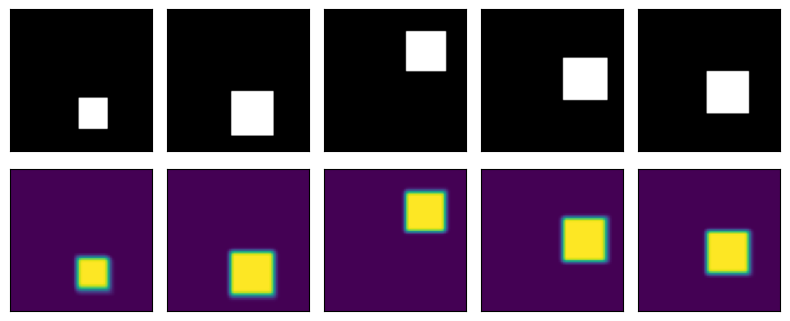

In [62]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3.5), sharex=True, sharey=True)

for i, ax in enumerate(axes[0]):
    ax.imshow(smpl_images[i].transpose(1, 2, 0), cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

gen_imgs = post_samples['imgs'].mean(0)
for i, ax in enumerate(axes[1]):
    ax.imshow(gen_imgs[i].transpose(1, 2, 0), vmin=0, vmax=1.)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

In [42]:
optim = optax.adabelief(1e-3)
loss = TraceMeanField_ELBO(16)

elbos = []
for z_dim in [3]:
    key, _key = jr.split(key)
    vae = VAE(key, z_dim, img_size, hidden_dim_enc=8)

    scaled_model = handlers.scale(vae.model, scale=1./ (len(data_indexes)))
    scaled_guide = handlers.scale(vae.ai_guide, scale=1. / (len(data_indexes)))
    svi = SVI(scaled_model, scaled_guide, optim, loss)

    num_iters = 1_000
    key, _key = jr.split(key)
    res = svi.run(_key, num_iters, test_img, batch_size=128, data=task.imgs[data_indexes])

    elbos.append( res.losses[-100:].mean() )

100%|██████████| 1000/1000 [00:08<00:00, 112.21it/s, init loss: 7089.1982, avg. loss [951-1000]: 7063.3540]


In [43]:
num_imgs = 5

key, _key = jr.split(key)
smpl_images = jr.choice(_key, train_data, shape=(num_imgs,))

pred = Predictive(vae.ai_guide, params=res.params, num_samples=100)
key, _key = jr.split(key)
samples = pred(_key, test_img, batch_size=None, data=smpl_images)
z_loc = samples['loc'].mean(0)

pred = Predictive(vae.model, params=res.params, posterior_samples=samples)
key, _key = jr.split(key)
post_samples = pred(_key, test_img, batch_size=None, data=smpl_images)

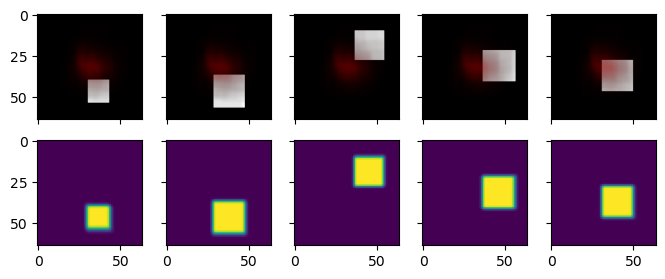

In [44]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes[0]):
    ax.imshow(smpl_images[i].transpose(1, 2, 0), cmap='Greys_r')
    ax.imshow(prior_img)

gen_imgs = post_samples['imgs'].mean(0)
for i, ax in enumerate(axes[1]):
    ax.imshow(gen_imgs[i].transpose(1, 2, 0), vmin=0, vmax=1)

In [ ]:
optim = optax.adabelief(1e-3)
loss = TraceMeanField_ELBO(1)

elbos = []
for z_dim in [3]:
    key, _key = jr.split(key)
    vae = VAE(key, z_dim, img_size)

    scaled_model = handlers.scale(vae.model, scale=1./ (len(data_indexes)))
    scaled_guide = handlers.scale(vae.iai_guide, scale=1. / (len(data_indexes)))
    svi = SVI(scaled_model, scaled_guide, optim, loss)

    num_iters = 1000
    key, _key = jr.split(key)
    res = svi.run(_key, num_iters, test_img, batch_size=128, data=task.imgs[data_indexes])

    elbos.append( res.losses[-100:].mean() )

100%|██████████| 1000/1000 [00:06<00:00, 157.09it/s, init loss: 7142.2314, avg. loss [951-1000]: 7071.7617]


In [ ]:
num_imgs = 5

key, _key = jr.split(key)
smpl_images = jr.choice(_key, task.imgs[data_indexes], shape=(num_imgs,))

pred = Predictive(vae.ai_guide, params=res.params, num_samples=100)
key, _key = jr.split(key)
samples = pred(_key, test_img, batch_size=None, data=smpl_images)
z_loc = samples['loc'].mean(0)

pred = Predictive(vae.model, params=res.params, posterior_samples=samples)
key, _key = jr.split(key)
post_samples = pred(_key, test_img, batch_size=None, data=smpl_images)

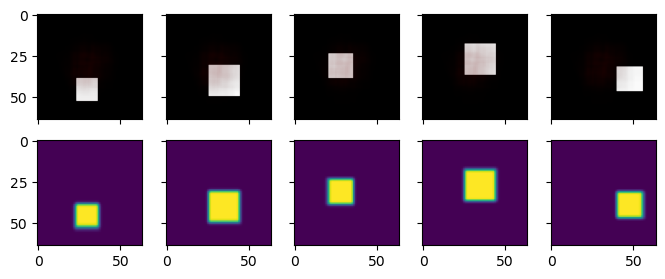

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes[0]):
    ax.imshow(smpl_images[i].transpose(1, 2, 0), cmap='Greys_r')
    ax.imshow(prior_img)

gen_imgs = post_samples['imgs'].mean(0)
for i, ax in enumerate(axes[1]):
    ax.imshow(gen_imgs[i].transpose(1, 2, 0), vmin=0, vmax=1)

In [ ]:
num_imgs = 5

key, _key = jr.split(key)
smpl_images = jr.choice(_key, task.imgs[data_indexes], shape=(num_imgs,))

pred = Predictive(vae.iai_guide, params=res.params, num_samples=100)
key, _key = jr.split(key)
samples = pred(_key, test_img, batch_size=None, data=smpl_images)
z_loc = samples['loc'].mean(0)

pred = Predictive(vae.model, params=res.params, posterior_samples=samples)
key, _key = jr.split(key)
post_samples = pred(_key, test_img, batch_size=None, data=smpl_images)

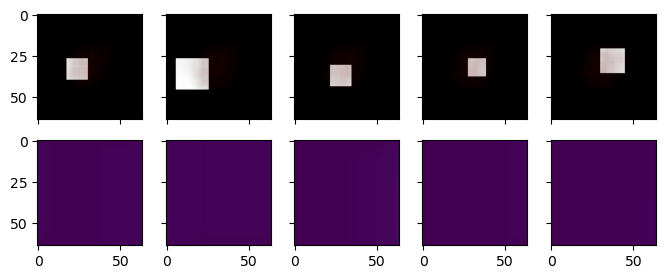

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes[0]):
    ax.imshow(smpl_images[i].transpose(1, 2, 0), cmap='Greys_r')
    ax.imshow(prior_img)

gen_imgs = post_samples['imgs'].mean(0)
for i, ax in enumerate(axes[1]):
    ax.imshow(gen_imgs[i].transpose(1, 2, 0), vmin=0, vmax=1)

In [ ]:
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(title, X, y, target_names, images):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for j, name in enumerate(target_names):
        ax.scatter(
            *X[y == name].T,
            marker="d",
            s=20,
            color=plt.cm.Dark2(j),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 5 * 1e-2:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], zoom=.25, cmap=plt.cm.gray_r), X[i], boxcoords="offset points",
             arrowprops=dict(arrowstyle="->")
        )
        imagebox.set(zorder=10)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

In [ ]:
from sklearn.manifold import TSNE

X = task.imgs[data_indexes].reshape(len(data_indexes), -1)
X_embedded = TSNE(
    n_components=2, 
    learning_rate='auto',
    perplexity=30
).fit_transform(X)
X_embedded.shape

(6144, 2)

In [ ]:
pred = Predictive(vae.ai_guide, params=res.params, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key, test_img, batch_size=None, data=task.imgs[data_indexes])
z_loc = samples['loc'].mean(0)

z_embedded = TSNE(
    n_components=2, 
    learning_rate='auto',
    perplexity=30
).fit_transform(z_loc)

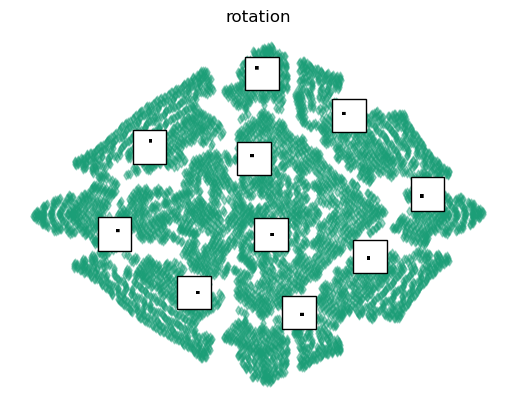

In [ ]:
target_names = np.arange(task.state_sizes[3])[::4]
y = states[:, 3]
plot_embedding('rotation', X_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))

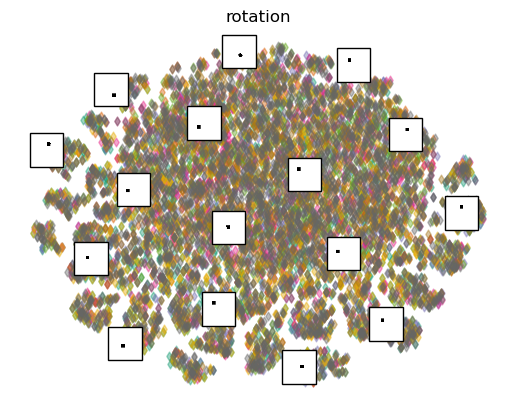

In [ ]:
target_names = np.arange(task.state_sizes[3])[::4]
y = states[:, 3]
plot_embedding('rotation', z_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))

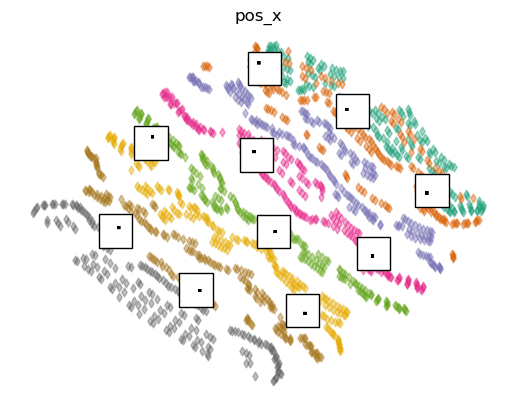

In [ ]:
s = 4
target_names = np.arange(task.state_sizes[s])[::4]
y = states[:, s]
plot_embedding('pos_x', X_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))

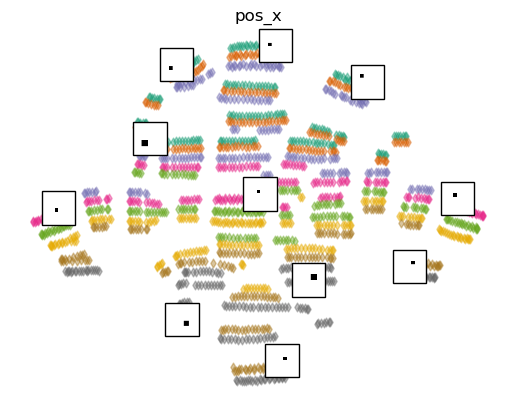

In [ ]:
s = 4
target_names = np.arange(task.state_sizes[s])[::4]
y = states[:, s]
plot_embedding('pos_x', z_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))

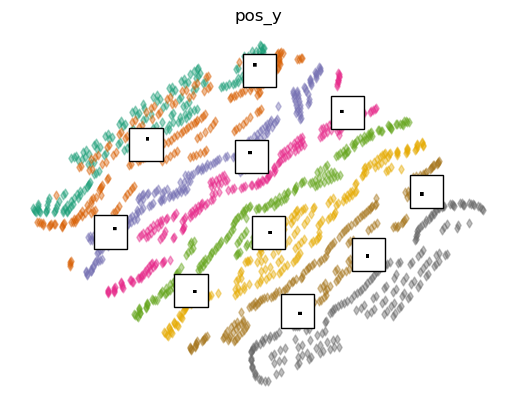

In [ ]:
s = 5
target_names = np.arange(task.state_sizes[s])[::4]
y = states[:, s]
plot_embedding('pos_y', X_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))

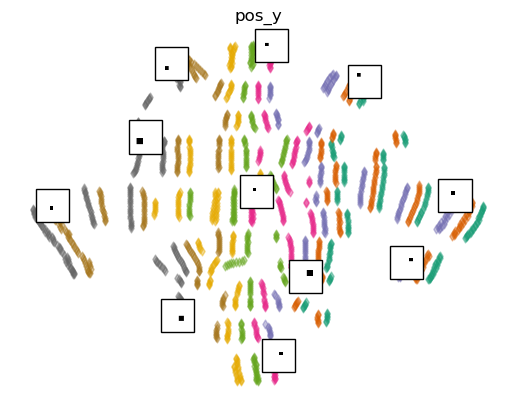

In [ ]:
s = 5
target_names = np.arange(task.state_sizes[s])[::4]
y = states[:, s]
plot_embedding('pos_y', z_embedded, y, target_names, task.imgs[data_indexes].transpose(0, 2, 3, 1))